In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:

num_qubits = 4 
dev = qml.device('default.qubit', wires=num_qubits)

In [3]:
"""

import matplotlib.pyplot as plt

# sample data
np.random.seed(3)  
data_x = np.random.rand(300, 2)   #features
data_y = np.random.randint(0, 2, 300)  #binary labels

# Plotting the data
plt.figure(figsize=(8, 6))
plt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')
plt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')
plt.title('Sample Data Plot')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()
"""


"\n\nimport matplotlib.pyplot as plt\n\n# sample data\nnp.random.seed(3)  \ndata_x = np.random.rand(300, 2)   #features\ndata_y = np.random.randint(0, 2, 300)  #binary labels\n\n# Plotting the data\nplt.figure(figsize=(8, 6))\nplt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')\nplt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')\nplt.title('Sample Data Plot')\nplt.xlabel('Feature 1')\nplt.ylabel('Feature 2')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [4]:
def batch_data(data_x, data_y, batch_size):
    """
    Generator function to yield batches of data.
    
    Parameters:
    - data_x: NumPy array of input features, shape (total_samples, features)
    - data_y: NumPy array of labels, shape (total_samples,)
    - batch_size: integer, size of each batch
    
    Yields:
    - batch_x: NumPy array of features for the batch
    - batch_y: NumPy array of labels for the batch
    """
    total_samples = data_x.shape[0]
    indices = np.arange(total_samples)
    np.random.shuffle(indices)  # Shuffle the data
    
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        batch_indices = indices[start_idx:end_idx]
        batch_x = data_x[batch_indices]
        batch_y = data_y[batch_indices]
        yield (batch_x, batch_y)

# Example usage:
# for batch_x, batch_y in batch_data(data_x, data_y, 10):
#     print(batch_x, batch_y)

In [5]:
def func_phi(w1,w2):
    return (w1-w2)**2

In [6]:
def ansatz(params):
    qml.RY(params[0],wires=[0])
    qml.RY(params[1],wires=[1])
    qml.CZ(wires=[0,1])

In [7]:
# Data Embedding for batch size = 4
def data_embedding_batch4(batch_x):
    for i in range(len(batch_x)):
        x = batch_x[i]
        phi = func_phi(x[0],x[1])
        qml.ctrl(qml.RY,control=[2,3],control_values=[1,1])(phi,[0])
        qml.ctrl(qml.RY,control=[2,3],control_values=[1,1])(phi,[1])
        if(i==0):
            qml.PauliX(wires=[3])
        elif(i==1):
            qml.PauliX(wires=[2])
            qml.PauliX(wires=[3])
        elif(i==2):
            qml.PauliX(3)
    # qml.Barrier(only_visual=True)
    qml.PauliX(wires=[2])
    qml.PauliX(wires=[3])
   
        


In [8]:
# Data Embedding for batch size = 1
def data_embedding_batch1(batch_x):
    x = batch_x
    phi = func_phi(x[0],x[1])
    qml.ctrl(qml.RY,control=[2,3],control_values=[1,1])(phi,[0])
    qml.ctrl(qml.RY,control=[2,3],control_values=[1,1])(phi,[1])

    # qml.Barrier(only_visual=True)
    qml.PauliX(wires=[2])
    qml.PauliX(wires=[3])
   



In [9]:
def adjoint_data_embedding_batch4(batch_x):
    qml.PauliX(wires=[2])
    qml.PauliX(wires=[3])
    last_index=len(batch_x)-1
    for i in range(len(batch_x)):
        x = batch_x[last_index-i]
        phi = func_phi(x[0],x[1])
        qml.ctrl(qml.adjoint(qml.RY),control=[2,3],control_values=[1,1])(phi,[1])
        qml.ctrl(qml.adjoint(qml.RY),control=[2,3],control_values=[1,1])(phi,[0])
        if(i==last_index-3):
            qml.PauliX(wires=[3])
        elif(i==last_index-2):
            qml.PauliX(wires=[2])
            qml.PauliX(wires=[3])
        elif(i==last_index-1):
            qml.PauliX(3)


In [10]:
def adjoint_data_embedding_batch1(batch_x):
    x = batch_x
    phi = func_phi(x[0],x[1])
    qml.PauliX(wires=[2])
    qml.PauliX(wires=[3])

    qml.ctrl(qml.adjoint(qml.RY),control=[2,3],control_values=[1,1])(phi,[1])
    qml.ctrl(qml.adjoint(qml.RY),control=[2,3],control_values=[1,1])(phi,[0])


In [11]:
def adjoint_ansatz(params):
        qml.CZ(wires=[0,1])
        qml.adjoint(qml.RY)(params[1],wires=[1])
        qml.adjoint(qml.RY)(params[0],wires=[0])
        

In [12]:
def buildGroverOracleAndDiffuserWithInverse(params,data):
    data_embedding_batch4(data)
    # qml.Barrier()
    ansatz(params)
    # qml.Barrier()
    qml.CCZ(wires=[0,2,3])
    # qml.Barrier()
    adjoint_ansatz(params)
    # qml.Barrier()
    adjoint_data_embedding_batch4(data)
    qml.templates.GroverOperator(wires=[2,3])

In [13]:
def buildGroverOracleAndDiffuserWithInverse1xbatch(params,data):
    data_embedding_batch1(data)
    # qml.Barrier()
    ansatz(params)
    # qml.Barrier()
    qml.CCZ(wires=[0,2,3])
    # qml.Barrier()
    adjoint_ansatz(params)
    # qml.Barrier()
    adjoint_data_embedding_batch1(data)
    qml.templates.GroverOperator(wires=[2,3])

In [14]:
def buildGroverOracleDifusserNoInverse(params,data):
    data_embedding_batch4(data)
    # qml.Barrier(only_visual=True)
    ansatz(params)
    qml.CCZ(wires=[0,2,3])
    qml.templates.GroverOperator(wires=[2,3])

In [15]:
def buildGroverOracleDifusserNoInverse1xbatch(params,data):
    data_embedding_batch1(data)
    # qml.Barrier(only_visual=True)
    ansatz(params)
    qml.CCZ(wires=[0,2,3])
    qml.templates.GroverOperator(wires=[2,3])
   

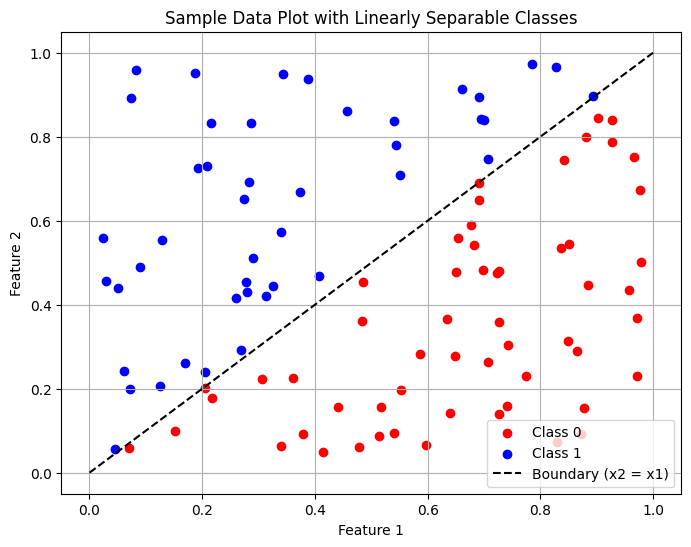

In [73]:
# import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(3)

# Generate random features
data_x = np.random.rand(100, 2)  # 300 samples, 2 features

# Assign labels based on a linear separator
# Example: label 1 if feature2 > feature1 (i.e., above the line x2 = x1), else label 0
data_y = (data_x[:, 1] > data_x[:, 0]).astype(int)

# Plotting the data
plt.figure(figsize=(8, 6))
plt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')
plt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')


# print(data_x)
# print(data_y)
# for i in range(len(data_x)):
#     print(data_x[i],data_y[i])

# Draw the line x2 = x1 to show the boundary
plt.plot([0, 1], [0, 1], 'k--', label='Boundary (x2 = x1)')

plt.title('Sample Data Plot with Linearly Separable Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def homogeneous_batch_data(data_x, data_y, batch_size):
    """
    Function to return two lists of batches of data where all samples in a batch have the same label.
    
    Parameters:
    - data_x: NumPy array of input features, shape (total_samples, features)
    - data_y: NumPy array of labels, shape (total_samples,)
    - batch_size: integer, size of each batch
    
    Returns:
    - batch_x_list: list of NumPy arrays of features for each batch
    - batch_y_list: list of NumPy arrays of labels for each batch
    """
    batch_x_list = []
    batch_y_list = []
    # Segregate data by labels
    unique_labels = np.unique(data_y)
    for label in unique_labels:
        # Extract all samples with the current label
        label_indices = np.where(data_y == label)[0]
        np.random.shuffle(label_indices)  # Shuffle indices to randomize batch content
        
        for start_idx in range(0, len(label_indices), batch_size):
            end_idx = min(start_idx + batch_size, len(label_indices))
            if(end_idx-start_idx!=batch_size):
                break
            batch_indices = label_indices[start_idx:end_idx]
            batch_x = data_x[batch_indices]
            batch_y = data_y[batch_indices]
            batch_x_list.append(batch_x)
            batch_y_list.append(batch_y)
    
    return batch_x_list, batch_y_list

# Example usage:
# Suppose data_x and data_y are already defined
# batch_x_list, batch_y_list = homogeneous_batch_data(data_x, data_y, 10)
# for batch_x, batch_y in zip(batch_x_list, batch_y_list):
#     print("Batch X:", batch_x)
#     print("Batch Y:", batch_y)

In [18]:
# batch_generator = homogeneous_batch_data(data_x, data_y, 4)
# batch_x, batch_y = next(batch_generator)


proj_1 = np.array([[0, 0], [0, 1]])


identity = np.eye(2)

proj_11 = np.array([[0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [0, 0, 0, 1]])

M_operator = np.kron(proj_1, np.kron(identity, proj_11))

numberOfGroverIteration = 3

@qml.qnode(dev)
def qnn_grover_circuit(params, data):
    hadmadard_range = range(2,4)
    for i in hadmadard_range:
        qml.Hadamard(wires=i)
    for i in range(numberOfGroverIteration):
        qml.Barrier(only_visual=True)
        buildGroverOracleAndDiffuserWithInverse(params,data)
    qml.Barrier(only_visual=True)
    buildGroverOracleDifusserNoInverse(params,data)

    return qml.expval(qml.Hermitian(M_operator, wires=[0, 1,2,3]))


print(qml.draw(qnn_grover_circuit)([0.1,0.2],[[0.1,0.1],[0.2,0.2],[0.3,0.3],[0.4,0.4]]))
batch_x_test, batch_y_test= homogeneous_batch_data(data_x, data_y, 4)
print(qnn_grover_circuit([0.1,0.2],batch_x_test[0]))





0: ─────||─╭RY(0.00)──────────────╭RY(0.00)──────────────╭RY(0.00)──────────────╭RY(0.00)──RY(0.10)
1: ─────||─│─────────╭RY(0.00)────│─────────╭RY(0.00)────│─────────╭RY(0.00)────│─────────╭RY(0.00)
2: ──H──||─├●────────├●───────────├●────────├●─────────X─├●────────├●───────────├●────────├●───────
3: ──H──||─╰●────────╰●─────────X─╰●────────╰●─────────X─╰●────────╰●─────────X─╰●────────╰●───────

────────────╭●─╭●─╭●──RY(0.10)†────────────╭RY(0.00)†───────────────╭RY(0.00)†──────────────
───RY(0.20)─╰Z─│──╰Z──RY(0.20)†─╭RY(0.00)†─│─────────────╭RY(0.00)†─│─────────────╭RY(0.00)†
───X───────────├●──X────────────├●─────────├●────────────├●─────────├●──────────X─├●────────
───X───────────╰Z──X────────────╰●─────────╰●──────────X─╰●─────────╰●──────────X─╰●────────

──╭RY(0.00)†───────────────╭RY(0.00)†──────────────────||─╭RY(0.00)──────────────╭RY(0.00)──────────
──│─────────────╭RY(0.00)†─│───────────────────────────||─│─────────╭RY(0.00)────│─────────╭RY(0.00)
──├●────────────├●──────

In [19]:
def signFunction(x):
    if(x>0):
        return 1
    else:
        return -1

In [20]:
batch_x_list, batch_y_list= homogeneous_batch_data(data_x, data_y, 4)
# print(batch_x_list)
# print(batch_y_list)


optimizer = qml.AdamOptimizer()
np.random.seed(30)
params = np.random.random([2])


# def cost(params):
#     loss_t = []
#     for batch_x,batch_y in homogeneous_batch_data(data_x, data_y, 4):
#         label = batch_y[0]
#         prob_last = qnn_grover_circuit(params, batch_x)[-1]
#         # loss_batch= ((prob_last - label)**2).mean()
#         loss_batch = (prob_last - label)**2
#         loss_t+=loss_batch
#     return loss_t.mean()
#     return ((prob_last - label)**2).mean()
def cost(params):
    loss_t = []
    for batch_x, batch_y in zip(batch_x_list, batch_y_list):
        label = batch_y[0]
        # if(label==0):
        #      continue
        exp_val = qnn_grover_circuit(params, batch_x)
        sign = signFunction(0.5-label)
        l_i = sign*exp_val
        loss_t.append(l_i) 
    # print(loss_t)
    loss_t = np.array(loss_t)
    return np.sum(loss_t)  



print(params)
# throw Exception
print(cost(params))

new_cost = 0

for it in range(1000):  
        # params, new_cost = optimizer.step_and_cost(lambda v: cost(v), params)
        params, new_cost = optimizer.step_and_cost(lambda v: cost(v), params)
        print(params)
        print(f'Iteration {it+1}: cost = {new_cost}')

print(new_cost)
print(params)

[0.64414354 0.38074849]
-0.10933830665209193
[0.63414354 0.38074849]
Iteration 1: cost = -0.10933830665209193
[0.62414907 0.38074849]
Iteration 2: cost = -0.11719730396954393
[0.614164   0.38074849]
Iteration 3: cost = -0.12488728266179534
[0.60419235 0.38074849]
Iteration 4: cost = -0.13240486091387926
[0.59423828 0.38074849]
Iteration 5: cost = -0.13974683250469572
[0.58430606 0.38074849]
Iteration 6: cost = -0.14691018395546207
[0.5744001  0.38074849]
Iteration 7: cost = -0.15389211129455888
[0.5645249  0.38074849]
Iteration 8: cost = -0.16069003624984216
[0.55468511 0.38074849]
Iteration 9: cost = -0.16730162172939747
[0.54488545 0.38074849]
Iteration 10: cost = -0.17372478646264872
[0.53513074 0.38074849]
Iteration 11: cost = -0.17995771868114702
[0.52542589 0.38074849]
Iteration 12: cost = -0.18599888872602907
[0.51577587 0.38074849]
Iteration 13: cost = -0.19184706047752784
[0.50618575 0.38074849]
Iteration 14: cost = -0.1975013015111145
[0.49666062 0.38074849]
Iteration 15: cos

KeyboardInterrupt: 

In [21]:
print(new_cost)
print(params)

-0.29145737296280505
[0.19326826 0.38074849]


In [40]:
dev2 = qml.device('default.qubit', wires=2)
@qml.qnode(dev2)
def predict_circuit(params, x):
    phi = func_phi(x[0],x[1])
    qml.RY(phi,wires=[0])
    qml.RY(phi,wires=[1])
    ansatz(params=params)

    return qml.probs(wires=[0])

In [52]:
predict_circuit(params=params,x=[0.3,0.8])

tensor([0.95167738, 0.04832262], requires_grad=True)

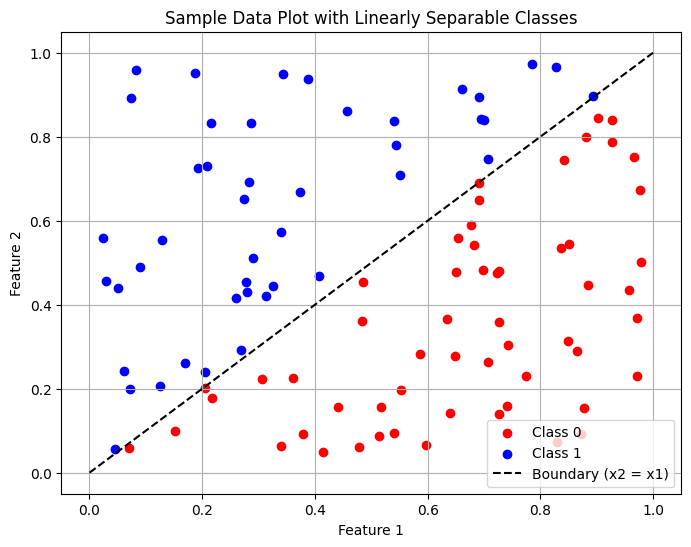

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')
plt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')

# Draw the line x2 = x1 to show the boundary
plt.plot([0, 1], [0, 1], 'k--', label='Boundary (x2 = x1)')

plt.title('Sample Data Plot with Linearly Separable Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
def predict(params,x):
    prob = predict_circuit(params,x)[0]
    if(prob>1/2):
        return 1
    else:
        return 0


In [103]:
def convertXtoLabel(f0,f1):
    if(f0>f1): return 0
    else: return 1


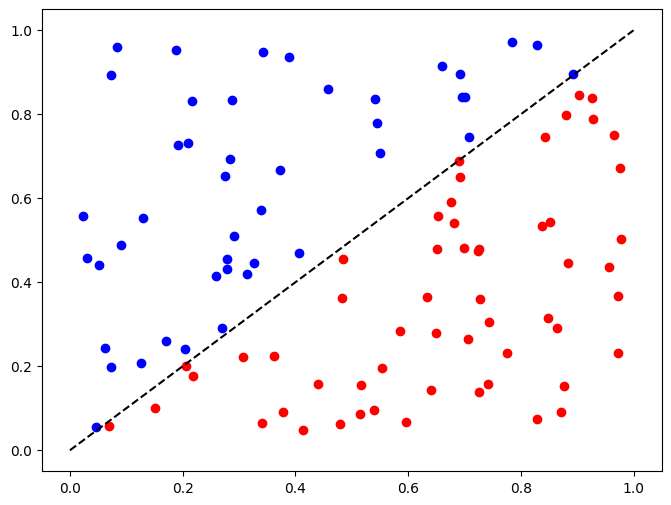

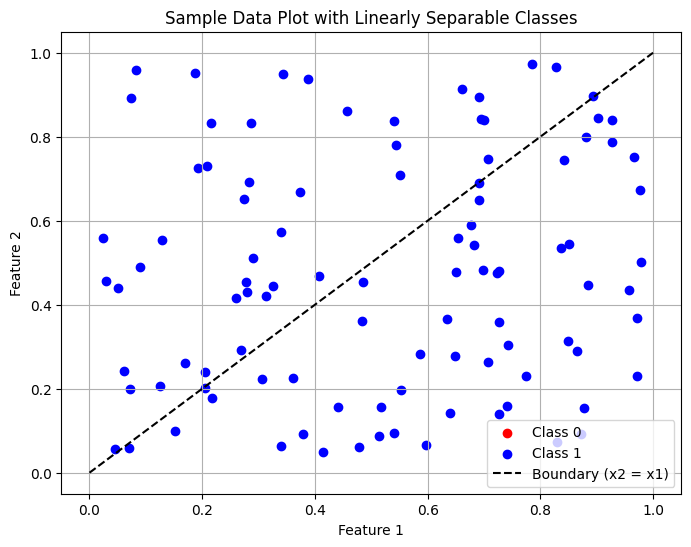

In [113]:

x1_0,y1_0 =[],[]
x1_1,y1_1 = [],[]
xp_0,yp_0 =[],[]
xp_1,yp_1 =[],[]
for f in data_x:
    label_exact_x1_y1= convertXtoLabel(f[0],f[1])
    if(label_exact_x1_y1==0):
        x1_0.append(f[0])
        y1_0.append(f[1])
    else:
        x1_1.append(f[0])
        y1_1.append(f[1])
    label_predict_xp= predict(params,f)
    if(label_predict_xp==0):
        xp_0.append(f[0])
        yp_0.append(f[1])
    else:
        xp_1.append(f[0])
        yp_1.append(f[1])


# print(data_x[data_y_predict == 0])
plt.figure(figsize=(8, 6))
plt.scatter(x1_0, y1_0, color='red', label='Class 0')
plt.scatter(x1_1, y1_1, color='blue', label='Class 1')
plt.plot([0, 1], [0, 1], 'k--', label='Boundary (x2 = x1)')

plt.figure(figsize=(8, 6))
plt.scatter(xp_0, yp_0, color='red', label='Class 0')
plt.scatter(xp_1, yp_1, color='blue', label='Class 1')

# Draw the line x2 = x1 to show the boundary
plt.plot([0, 1], [0, 1], 'k--', label='Boundary (x2 = x1)')

plt.title('Sample Data Plot with Linearly Separable Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


# for i in range(len(data_y)):
#     print('real y = ',data_y[i], 'predict y',data_y_predict[i])

In [53]:
# data_y_predict =[]
# for x in data_x:
#     predict = predict_circuit(params,x)[0]
#     data_y_predict.append(predict)

# for i in range(len(data_y)):
#     print('real y = ',data_y[i], 'predict y',data_y_predict[i])


real y =  1 predict y 0.9881630308965521
real y =  1 predict y 0.9854740974199138
real y =  1 predict y 0.9906898008758873
real y =  1 predict y 0.9900396240238323
real y =  1 predict y 0.9705620804005175
real y =  1 predict y 0.9651510812651729
real y =  0 predict y 0.9729149959379503
real y =  0 predict y 0.9899775782627914
real y =  1 predict y 0.9436459394887263
real y =  1 predict y 0.9882138261630348
real y =  1 predict y 0.9677630453059451
real y =  0 predict y 0.9813901485877908
real y =  1 predict y 0.9846034917415056
real y =  0 predict y 0.98999425537773
real y =  1 predict y 0.9402158639683763
real y =  0 predict y 0.9797677497862717
real y =  0 predict y 0.9903753463890512
real y =  0 predict y 0.9812211830075135
real y =  0 predict y 0.9897932828885392
real y =  0 predict y 0.9888161901559194
real y =  1 predict y 0.9903129767367611
real y =  1 predict y 0.9906419481113662
real y =  1 predict y 0.9687268245833037
real y =  0 predict y 0.9798399732015707
real y =  1 predic